In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


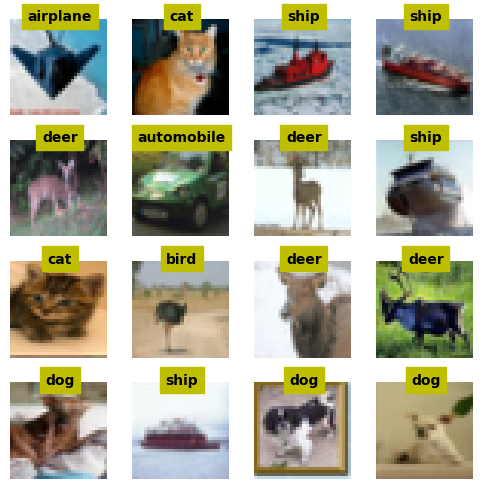

In [8]:
X, y = next(iter(train_loader))

fig, axs = plt.subplots(4,4,figsize=(5,5))

for (i,ax) in enumerate(axs.flatten()):
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5

  label = trainset.classes[y[i]]

  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [29]:
def create_model():
    class Model(nn.Module):
        def __init__(self):
            super().__init__()

            # encoding layers
            self.conv1 = nn.Conv2d(3,16,4,padding=1,stride=2)
            self.conv2 = nn.Conv2d(16,32,4,padding=1,stride=2)
            self.latent = nn.Conv2d(32,64,4,padding=1,stride=2)

            # decoding layers
            self.conv3 = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)
            self.conv4 = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
            self.output = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.latent(x))
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            x = F.relu(self.output(x))
            return x
    
    model = Model()
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001, weight_decay=1e-5)

    return model, loss_fun, optimizer



In [30]:
model, loss_fun, optimizer = create_model()

In [33]:
def train_model():
    EPOCHS = 30
    model.to(device)

    train_loss = torch.zeros(EPOCHS)
    test_loss = torch.zeros(EPOCHS)

    for i in range(EPOCHS):
        model.train()
        batch_loss =[]

        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

            train_loss[i] = np.mean(batch_loss)

        model.eval()
        batch_loss = []

        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            
            with torch.inference_mode():
                y_hat = model(X)
                loss = loss_fun(y_hat, X)

            batch_loss. append(loss.item())

        test_loss[i] = np.mean(batch_loss)
    return train_loss, test_loss, model    

In [34]:
train_loss, test_loss, model = train_model()

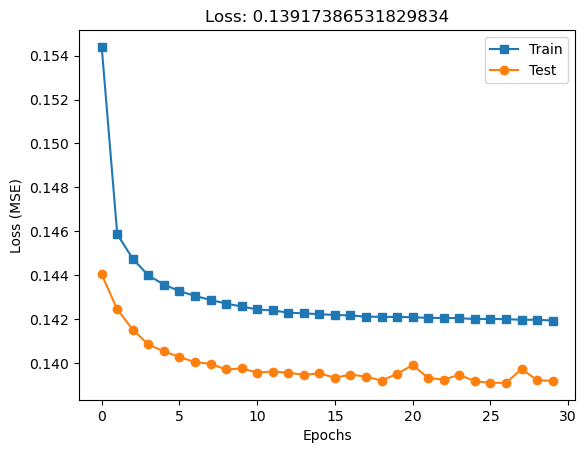

In [35]:
plt.plot(train_loss,'s-',label='Train')
plt.plot(test_loss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title(f'Loss: {test_loss[-1]}')
plt.legend()

plt.show()